✅ Étape 1 : Import des bibliothèques

In [1]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from openbabel import pybel
from tqdm.notebook import tqdm


✅ Étape 2 : Chargement de la base de données



In [2]:
df = pd.read_csv("smiles_select_GDB9.csv")  # Le fichier doit contenir une colonne "SMILES"
df["Molecule"] = [Chem.MolFromSmiles(sm) for sm in df["SMILES"]]
df = df.dropna(subset=["Molecule"]).reset_index(drop=True)


In [3]:
df

,mol_id,SMILES,formula,pce_pcbm(%),pce_pcdtbt(%),sas1(%),pce_pcbm_sas(%),pce_pcdtbt_sas(%),type,Molecule
0,977,O=O,O2,8.661863,0.000000,3.373829,5.288034,-3.373829,accepteur,<rdkit.Chem.rdchem.Mol object at 0x74d316febb50>
1,1712,O=C1N=c2c(=C1CNc1ccc(cc1)S(=O)(=O)Nc1ccccn1)c1...,C21H15N5O3S2,8.503739,0.000000,7.227077,1.276662,-7.227077,accepteur,<rdkit.Chem.rdchem.Mol object at 0x74d316febbc0>
2,4550,O=NC1=c2cc(N(O)O)c3c(c2=NC1=O)CCCC3,C12H11N3O4,0.000000,16.886417,6.955664,-6.955664,9.930753,donneur,<rdkit.Chem.rdchem.Mol object at 0x74d316febc30>
3,7801,Oc1ccc(cc1)O.O=C1C=CC(=O)C=C1,C12H10O4,7.447933,0.000000,6.864235,0.583698,-6.864235,accepteur,<rdkit.Chem.rdchem.Mol object at 0x74d316febca0>
4,11029,[O-]C(=O)[O-].[Mg+2],CMgO3,0.000000,8.546781,4.861290,-4.861290,3.685491,donneur,<rdkit.Chem.rdchem.Mol object at 0x74d316febd10>
5,17851,CC[N-]c1nc(N[N+]#N)nc(n1)NC(C)C,C8H14N8,3.984198,36.108642,7.622432,-3.638234,28.486210,donneur,<rdkit.Chem.rdchem.Mol object at 0x74d316febd80>
6,20778,N#[N+]Nc1nc([N-]C(C)C)nc(n1)SC,C7H11N7S,0.000000,25.412759,7.206303,-7.206303,18.206457,donneur,<rdkit.Chem.rdchem.Mol object at 0x74d316febdf0>


✅ Étape 3 : Génération des structures 3D (.pdbqt) pour le docking

In [4]:
# 🧬 Étape 3 : Génération de structure 3D et conversion en .pdbqt
def generate_3d_structure(smiles, mol_id, out_dir="ligands_pdbqt"):
    os.makedirs(out_dir, exist_ok=True)
    
    mol = Chem.MolFromSmiles(smiles)
    
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.UFFOptimizeMolecule(mol)
    
    sdf_path = os.path.join(out_dir, f"{mol_id}.sdf")
    pdbqt_path = os.path.join(out_dir, f"{mol_id}.pdbqt")
    
    Chem.SDWriter(sdf_path).write(mol)
    
    mol_ob = next(pybel.readfile("sdf", sdf_path))
    mol_ob.make3D()
    mol_ob.addh()
    mol_ob.write("pdbqt", pdbqt_path, overwrite=True)
    
    return pdbqt_path


✅ Étape 5 : Lancement du docking avec Smina (ou vina)


✅ Étape 6 : Boucle sur les molécules

✅ Étape 7 : Filtrage des bons candidats

!obabel receptor.pdb -O receptor.pdbqt --gen3d


In [5]:
candidates = docking_df[docking_df["Affinity_kcal_mol"] < -6.0]
print("Top candidate molecules with medicinal potential:\n", candidates.head())


NameError: name 'docking_df' is not defined

import os
import time
import re

def run_docking(ligand_pdbqt, receptor="receptor.pdbqt", output_dir="docking_results", tool="smina"):
    os.makedirs(output_dir, exist_ok=True)

    if not os.path.exists(receptor):
        print(f"❌ Le fichier {receptor} est manquant.")
        return None

    basename = os.path.basename(ligand_pdbqt).replace('.pdbqt', '')
    output_file = os.path.join(output_dir, f"{basename}_out.pdbqt")
    log_file = os.path.join(output_dir, f"{basename}.log")

    cmd = f"{tool} --receptor {receptor} --ligand {ligand_pdbqt} " \
          f"--center_x 0 --center_y 0 --center_z 0 " \
          f"--size_x 20 --size_y 20 --size_z 20 " \
          f"--out {output_file} --log {log_file} --exhaustiveness 8"

    start_time = time.time()
    os.system(cmd)
    duration = time.time() - start_time
    print(f"🕒 Docking terminé en {duration:.2f} secondes.")

    # 🔍 Lire la première ligne réelle de résultats (mode 1)
    affinity = None
    try:
        with open(log_file, 'r') as f:
            found_table = False
            for line in f:
                if found_table:
                    if re.match(r'^\s*\d+\s+[-]?\d+\.\d+', line):  # première ligne de données
                        parts = line.strip().split()
                        affinity = float(parts[1])  # deuxième colonne = affinité
                        break
                elif line.strip().startswith("mode |"):
                    found_table = True  # prochaine ligne utile
    except Exception as e:
        print(f"⚠️ Erreur lors de la lecture du fichier log : {e}")

    if affinity is not None:
        print(f"✅ Affinité extraite : {affinity:.2f} kcal/mol")
    else:
        print("⚠️ Affinité non trouvée dans le fichier log.")

    return affinity


results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        ligand_path = generate_3d_structure(row["SMILES"], mol_id=row["mol_id"])
        score = run_docking(ligand_path, receptor="receptor.pdbqt", tool="smina")
        results.append({
            "ID": row["mol_id"],
            "SMILES": row["SMILES"],
            "Affinity_kcal_mol": score
        })
    except Exception as e:
        print(f"❌ Erreur pour {row['mol_id']}: {e}")
        results.append({
            "ID": row["mol_id"],
            "SMILES": row["SMILES"],
            "Affinity_kcal_mol": None
        })


import os, time, re, pandas as pd
from tqdm import tqdm

def run_docking(ligand_pdbqt, receptor, output_dir, tool="smina"):
    os.makedirs(output_dir, exist_ok=True)
    if not os.path.exists(receptor):
        return None, "Missing receptor"
    base = os.path.basename(ligand_pdbqt).replace('.pdbqt','')
    log = os.path.join(output_dir, f"{base}.log")
    cmd = (f"{tool} --receptor {receptor} --ligand {ligand_pdbqt} "
           f"--center_x 0 --center_y 0 --center_z 0 "
           f"--size_x 20 --size_y 20 --size_z 20 "
           f"--out {os.path.join(output_dir, base + '_out.pdbqt')} "
           f"--log {log} --exhaustiveness 10")
    t0 = time.time(); os.system(cmd); duration = time.time() - t0

    # Lecture du log pour extraire le mode 1
    affinity, found = None, False
    try:
        with open(log, 'r') as f:
            for line in f:
                if found and re.match(r'^\s*1\s+-?\d+\.\d+', line):
                    affinity = float(line.split()[1])
                    break
                if line.strip().startswith("mode |"):
                    found = True
    except FileNotFoundError:
        pass

    status = "OK" if affinity is not None else "Affinity not found"
    print(f"{os.path.basename(ligand_pdbqt)} → {status} ({affinity}) in {duration:.1f}s")
    return affinity, status

# On lit tous les ligands dans un dossier unique
ALL_LIGANDS_DIR = "ligands_pdbqt"  # <— changez-le si besoin
receptors = {
    "HIV1protease": "receptors/1DMP.pdbqt",
    "Hsp90":         "receptors/2XJX.pdbqt",
    "Proteasome":    "receptors/7PG9.pdbqt",
    # "PfNDH2":      "receptors/5JWA.pdbqt",
}

results = []
ligands = [f for f in os.listdir(ALL_LIGANDS_DIR) if f.endswith(".pdbqt")]

for target, rec in receptors.items():
    out_dir = os.path.join("results", target)
    for lig in tqdm(ligands, desc=target):
        lig_path = os.path.join(ALL_LIGANDS_DIR, lig)
        aff, status = run_docking(lig_path, rec, out_dir, tool="smina")
        results.append({
            "Target": target,
            "Ligand": lig,
            "Affinity": aff,
            "Status": status
        })

df = pd.DataFrame(results)
df.to_csv("dock_by_target.csv", index=False)
print(df.groupby("Target").Affinity.agg(["count","min","mean","max"]))


import os, time, re
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def extract_affinity_from_log(log_file):
    affinity, found = None, False
    try:
        with open(log_file, 'r') as f:
            for line in f:
                if found and re.match(r'^\s*1\s+-?\d+\.\d+', line):
                    affinity = float(line.split()[1])
                    break
                if line.strip().startswith("mode |"):
                    found = True
    except Exception:
        pass
    return affinity

def run_docking_fallback(ligand_pdbqt, receptor, output_dir, try_tools=["smina", "vina"]):
    os.makedirs(output_dir, exist_ok=True)
    base = os.path.basename(ligand_pdbqt).replace('.pdbqt', '')
    output_file = os.path.join(output_dir, base + '_out.pdbqt')
    log_file = os.path.join(output_dir, base + '.log')
    
    for tool in try_tools:
        cmd = f"{tool} --receptor {receptor} --ligand {ligand_pdbqt} " \
              f"--center_x 0 --center_y 0 --center_z 0 " \
              f"--size_x 20 --size_y 20 --size_z 20 " \
              f"--out {output_file} --log {log_file} --exhaustiveness 100"
        t0 = time.time()
        os.system(cmd)
        duration = time.time() - t0

        affinity = extract_affinity_from_log(log_file)
        if affinity is not None:
            print(f"✅ {tool.upper()} réussi pour {base} ({affinity:.2f} kcal/mol, {duration:.1f}s)")
            return affinity, tool
        else:
            print(f"⚠️ {tool} a échoué pour {base}")
    return None, "Failed"


ALL_LIGANDS_DIR = "ligands_pdbqt"
RECEPTORS = {
    "HIV1protease": "receptors/1DMP.pdbqt",
    "Hsp90":        "receptors/2XJX.pdbqt",
    "Proteasome":   "receptors/7PG9.pdbqt"
}

ligands = [f for f in os.listdir(ALL_LIGANDS_DIR) if f.endswith(".pdbqt")]
results = []

for lig in tqdm(ligands, desc="Docking total"):
    lig_path = os.path.join(ALL_LIGANDS_DIR, lig)
    result_row = {"Molecule": lig}
    for target, rec_path in RECEPTORS.items():
        out_dir = os.path.join("results", target)
        affinity, method = run_docking_fallback(lig_path, rec_path, out_dir)
        result_row[target] = affinity
        result_row[target + "_method"] = method
    results.append(result_row)

df = pd.DataFrame(results)
df.to_csv("docking_matrix.csv", index=False)
df.head()

candidates = docking_df[docking_df["Affinity_kcal_mol"] < -6.0]
print("Top candidate molecules with medicinal potential:\n", candidates.head())


import os
import time
import re
import pandas as pd
from tqdm import tqdm

# Fonction améliorée pour exécuter Smina/Vina et extraire l’affinité
def run_docking(ligand_pdbqt, receptor, output_dir, tool="smina"):
    os.makedirs(output_dir, exist_ok=True)
    if not os.path.exists(receptor):
        return None, "Missing receptor"
    
    base = os.path.basename(ligand_pdbqt).replace('.pdbqt','')
    log = os.path.join(output_dir, f"{base}.log")
    cmd = f"{tool} --receptor {receptor} --ligand {ligand_pdbqt} " \
          f"--center_x 0 --center_y 0 --center_z 0 " \
          f"--size_x 20 --size_y 20 --size_z 20 " \
          f"--out {os.path.join(output_dir, base + '_out.pdbqt')} " \
          f"--log {log} --exhaustiveness 8"
    
    t0 = time.time()
    os.system(cmd)
    duration = time.time() - t0

    affinity = None
    status = "OK"
    try:
        with open(log, 'r') as f:
            found = False
            for line in f:
                if found and re.match(r'^\s*1\s+-?\d+\.\d+', line):
                    affinity = float(line.split()[1])
                    break
                if line.strip().startswith("mode |"):
                    found = True
    except Exception as e:
        status = f"Log read error: {e}"

    if affinity is None:
        status = "Affinity not found"

    return affinity, status

# Boucle principale par cible
base = "ligands"
receptor_map = {
    "HIV1protease": "receptors/HIV1protease.pdbqt",
    "Hsp90": "receptors/Hsp90.pdbqt",
    "Proteasome": "receptors/Proteasome.pdbqt"
}

all_results = []

for target, receptor in receptor_map.items():
    lig_dir = os.path.join(base, target)
    out_dir = os.path.join("results", target)
    for lig in os.listdir(lig_dir):
        if not lig.endswith(".pdbqt"): continue
        lig_path = os.path.join(lig_dir, lig)
        aff, status = run_docking(lig_path, receptor, out_dir, tool="smina")
        all_results.append({
            "Target": target,
            "Ligand": lig,
            "Affinity_kcal_mol": aff,
            "Status": status
        })

# Création du DataFrame et export
df = pd.DataFrame(all_results)
df.to_csv("dock_results_by_target.csv", index=False)
print("🏁 Résultats enregistrés dans dock_results_by_target.csv")
print(df.groupby("Target")["Affinity_kcal_mol"].agg(['count','min','mean','max']))


from nbformat import v4, write
from pathlib import Path

# Création d’un notebook complet avec visualisation incluse
cells = []

# Importation des modules et fonctions de docking
cells.append(v4.new_markdown_cell("# 🔬 Docking croisé + Visualisation"))
cells.append(v4.new_code_cell("""\
import os, time, re
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def extract_affinity_from_log(log_file):
    affinity, found = None, False
    try:
        with open(log_file, 'r') as f:
            for line in f:
                if found and re.match(r'^\\s*1\\s+-?\\d+\\.\\d+', line):
                    affinity = float(line.split()[1])
                    break
                if line.strip().startswith("mode |"):
                    found = True
    except Exception:
        pass
    return affinity

def run_docking_fallback(ligand_pdbqt, receptor, output_dir, try_tools=["smina", "vina"]):
    os.makedirs(output_dir, exist_ok=True)
    base = os.path.basename(ligand_pdbqt).replace('.pdbqt', '')
    output_file = os.path.join(output_dir, base + '_out.pdbqt')
    log_file = os.path.join(output_dir, base + '.log')
    
    for tool in try_tools:
        cmd = f"{tool} --receptor {receptor} --ligand {ligand_pdbqt} " \\
              f"--center_x 0 --center_y 0 --center_z 0 " \\
              f"--size_x 20 --size_y 20 --size_z 20 " \\
              f"--out {output_file} --log {log_file} --exhaustiveness 8"
        t0 = time.time()
        os.system(cmd)
        duration = time.time() - t0

        affinity = extract_affinity_from_log(log_file)
        if affinity is not None:
            print(f"✅ {tool.upper()} réussi pour {base} ({affinity:.2f} kcal/mol, {duration:.1f}s)")
            return affinity, tool
        else:
            print(f"⚠️ {tool} a échoué pour {base}")
    return None, "Failed"
"""))

# Configuration + Boucle de docking
cells.append(v4.new_code_cell("""\
ALL_LIGANDS_DIR = "ligands_pdbqt"
RECEPTORS = {
    "HIV1protease": "receptors/1DMP.pdbqt",
    "Hsp90":        "receptors/2XJX.pdbqt",
    "Proteasome":   "receptors/7PG9.pdbqt"
}

ligands = [f for f in os.listdir(ALL_LIGANDS_DIR) if f.endswith(".pdbqt")]
results = []

for lig in tqdm(ligands, desc="Docking total"):
    lig_path = os.path.join(ALL_LIGANDS_DIR, lig)
    result_row = {"Molecule": lig}
    for target, rec_path in RECEPTORS.items():
        out_dir = os.path.join("results", target)
        affinity, method = run_docking_fallback(lig_path, rec_path, out_dir)
        result_row[target] = affinity
        result_row[target + "_method"] = method
    results.append(result_row)

df = pd.DataFrame(results)
df.to_csv("docking_matrix.csv", index=False)
df.head()"""))

# Visualisation
cells.append(v4.new_markdown_cell("## 📊 Visualisation des affinités par molécule et par cible"))
cells.append(v4.new_code_cell("""\
# Charger les résultats
df = pd.read_csv("docking_matrix.csv")

# Extraire les colonnes d’affinité
aff_cols = [col for col in df.columns if col not in ["Molecule"] and not col.endswith("_method")]
aff_data = df[["Molecule"] + aff_cols]

# Données format long
df_long = aff_data.melt(id_vars="Molecule", var_name="Target", value_name="Affinity")

# Plot
plt.figure(figsize=(10, 6))
heatmap_data = df_long.pivot(index="Molecule", columns="Target", values="Affinity")
sns.heatmap(heatmap_data, cmap="vlag", center=0, annot=True, fmt=".1f")
plt.title("Carte de chaleur des affinités (kcal/mol)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""))

# Sauvegarde du notebook
notebook = v4.new_notebook(cells=cells, metadata={"kernelspec": {"name": "python3", "display_name": "Python 3"}})
nb_path = Path("docking_plus_visualisation.ipynb")
with open(nb_path, "w", encoding="utf-8") as f:
    write(notebook, f)

nb_path.as_posix()


In [6]:
import os, time, re
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser

def compute_box_from_pdb(pdb_path, padding=6.0):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("receptor", pdb_path)
    atoms = [atom.coord for atom in structure.get_atoms() if atom.element != "H"]
    coords = np.array(atoms)
    min_corner = coords.min(axis=0)
    max_corner = coords.max(axis=0)
    center = coords.mean(axis=0)
    size = (max_corner - min_corner) + padding
    return center, size

def extract_affinity_from_log(log_file):
    affinity, found = None, False
    try:
        with open(log_file, 'r') as f:
            for line in f:
                if found and re.match(r'^\s*1\s+-?\d+\.\d+', line):
                    affinity = float(line.split()[1])
                    break
                if line.strip().startswith("mode |"):
                    found = True
    except Exception:
        pass
    return affinity

def run_docking_fallback(ligand_pdbqt, receptor_pdbqt, receptor_pdb, output_dir, try_tools=["smina", "vina"]):
    os.makedirs(output_dir, exist_ok=True)
    base = os.path.basename(ligand_pdbqt).replace('.pdbqt', '')
    output_file = os.path.join(output_dir, base + '_out.pdbqt')
    log_file = os.path.join(output_dir, base + '.log')
    
    center, size = compute_box_from_pdb(receptor_pdb)
    cx, cy, cz = center
    sx, sy, sz = size

    for tool in try_tools:
        cmd = f"{tool} --receptor {receptor_pdbqt} --ligand {ligand_pdbqt} " \
              f"--center_x {cx:.5f} --center_y {cy:.5f} --center_z {cz:.5f} " \
              f"--size_x {sx:.5f} --size_y {sy:.5f} --size_z {sz:.5f} " \
              f"--out {output_file} --log {log_file} --exhaustiveness 100"
        t0 = time.time()
        os.system(cmd)
        duration = time.time() - t0

        affinity = extract_affinity_from_log(log_file)
        if affinity is not None:
            print(f"✅ {tool.upper()} réussi pour {base} ({affinity:.5f} kcal/mol, {duration:.5f}s)")
            return affinity, tool
        else:
            print(f"⚠️ {tool} a échoué pour {base}")
    return None, "Failed"


In [7]:
ALL_LIGANDS_DIR = "ligands_pdbqt"
RECEPTORS = {
    # "HIV1protease": ("receptors/1DMP.pdbqt", "receptors/1DMP.pdb"),
    # "Hsp90":        ("receptors/2XJX.pdbqt", "receptors/2XJX.pdb"),
    # "Proteasome":   ("receptors/7PG9.pdbqt", "receptors/7PG9.pdb"),
    "Neurodegenerative (1SYH)": ("receptors/1SYH.pdbqt", "receptors/1SYH.pdb"),
    "Malaria COPD (4LDE)": ("receptors/4LDE.pdbqt", "receptors/4LDE.pdb"),
    "COVID-19 (6Y2F)": ("receptors/6Y2F.pdbqt", "receptors/6Y2F.pdb")
}

ligands = [f for f in os.listdir(ALL_LIGANDS_DIR) if f.endswith(".pdbqt")]
results = []

for lig in tqdm(ligands, desc="Docking total"):
    lig_path = os.path.join(ALL_LIGANDS_DIR, lig)
    result_row = {"Molecule": lig}
    for target, (rec_pdbqt, rec_pdb) in RECEPTORS.items():
        out_dir = os.path.join("results", target)
        affinity, method = run_docking_fallback(lig_path, rec_pdbqt, rec_pdb, out_dir)
        result_row[target] = affinity
        result_row[target + "_method"] = method
    results.append(result_row)

df = pd.DataFrame(results)
df.to_csv("docking_matrix.csv", index=False)
df.head()


Docking total:   0%|                                                                                                                 | 0/7 [00:00<?, ?it/s]sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected


⚠️ smina a échoué pour 1712
⚠️ vina a échoué pour 1712
⚠️ smina a échoué pour 1712
⚠️ vina a échoué pour 1712


sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
Docking total:  14%|███████████████                                                                                          | 1/7 [00:00<00:01,  3.45it/s]sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected


⚠️ smina a échoué pour 1712
⚠️ vina a échoué pour 1712
⚠️ smina a échoué pour 977
⚠️ vina a échoué pour 977


sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
Docking total:  29%|██████████████████████████████                                                                           | 2/7 [00:00<00:01,  3.53it/s]sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected


⚠️ smina a échoué pour 977
⚠️ vina a échoué pour 977
⚠️ smina a échoué pour 977
⚠️ vina a échoué pour 977
⚠️ smina a échoué pour 17851
⚠️ vina a échoué pour 17851


sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
Docking total:  43%|█████████████████████████████████████████████                                                            | 3/7 [00:00<00:01,  3.79it/s]

⚠️ smina a échoué pour 17851
⚠️ vina a échoué pour 17851
⚠️ smina a échoué pour 17851
⚠️ vina a échoué pour 17851


sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
Docking total:  57%|████████████████████████████████████████████████████████████                                             | 4/7 [00:01<00:00,  3.53it/s]

⚠️ smina a échoué pour 7801
⚠️ vina a échoué pour 7801
⚠️ smina a échoué pour 7801
⚠️ vina a échoué pour 7801
⚠️ smina a échoué pour 7801
⚠️ vina a échoué pour 7801


sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
Docking total:  71%|███████████████████████████████████████████████████████████████████████████                              | 5/7 [00:01<00:00,  3.89it/s]

⚠️ smina a échoué pour 4550
⚠️ vina a échoué pour 4550
⚠️ smina a échoué pour 4550
⚠️ vina a échoué pour 4550
⚠️ smina a échoué pour 4550
⚠️ vina a échoué pour 4550


sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected


⚠️ smina a échoué pour 20778
⚠️ vina a échoué pour 20778


sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
Docking total:  86%|██████████████████████████████████████████████████████████████████████████████████████████               | 6/7 [00:01<00:00,  3.66it/s]sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected


⚠️ smina a échoué pour 20778
⚠️ vina a échoué pour 20778
⚠️ smina a échoué pour 20778
⚠️ vina a échoué pour 20778
⚠️ smina a échoué pour 11029
⚠️ vina a échoué pour 11029
⚠️ smina a échoué pour 11029
⚠️ vina a échoué pour 11029


sh: 1: Syntax error: "(" unexpected
sh: 1: Syntax error: "(" unexpected
Docking total: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.81it/s]

⚠️ smina a échoué pour 11029
⚠️ vina a échoué pour 11029


,Molecule,Neurodegenerative (1SYH),Neurodegenerative (1SYH)_method,Malaria COPD (4LDE),Malaria COPD (4LDE)_method,COVID-19 (6Y2F),COVID-19 (6Y2F)_method
0,1712.pdbqt,None,Failed,None,Failed,None,Failed
1,977.pdbqt,None,Failed,None,Failed,None,Failed
2,17851.pdbqt,None,Failed,None,Failed,None,Failed
3,7801.pdbqt,None,Failed,None,Failed,None,Failed
4,4550.pdbqt,None,Failed,None,Failed,None,Failed


/home/mvotokps/anaconda3/envs/Patrick/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/mvotokps/anaconda3/envs/Patrick/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


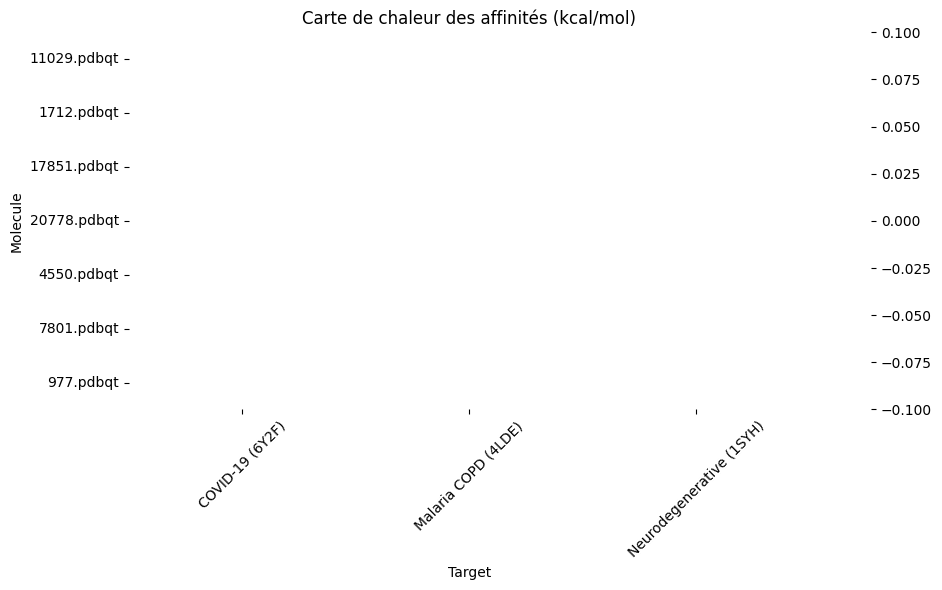

In [8]:
df = pd.read_csv("docking_matrix.csv")
aff_cols = [col for col in df.columns if col not in ["Molecule"] and not col.endswith("_method")]
df_long = df[["Molecule"] + aff_cols].melt(id_vars="Molecule", var_name="Target", value_name="Affinity")

plt.figure(figsize=(10, 6))
heatmap_data = df_long.pivot(index="Molecule", columns="Target", values="Affinity")
sns.heatmap(heatmap_data, cmap="vlag", center=0, annot=True, fmt=".1f")
plt.title("Carte de chaleur des affinités (kcal/mol)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
